# Demonstartion of PCFNet

This notebook is demostraion for PCFNet with mock data.
**Simulation data have to match the observed data consistently to conduct analysis similar to that of Takeda et al. (2024).**
However, it is useful to test PCFNet with mock data for understanding.

First, you have to make an environment to run PCFNet (see `Usage- 1.Setup` in the README.md).
After then, you can run this notebook.

# Import Libraries

In [1]:
import os
import warnings
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml 
from sklearn import metrics

from pcfnet.trainer import Trainer
from pcfnet.util import util

os.chdir('..')  # change to the root directory of the project
warnings.simplefilter("ignore")

# Mock Data Generation

In [2]:
np.random.seed(0)
config_file = "config/mock_configure.yaml"
args = yaml.load(open(config_file), Loader=yaml.FullLoader)
args["device"] = "cuda:0"
args = argparse.Namespace(**args)


In [ ]:
def generate_random_points_on_sphere(num_points, ramin=-np.pi/12, ramax=np.pi/12, decmin=-np.pi/12, decmax=np.pi/12, zmin=1, zmax=2):
    ra = np.random.rand(num_points) * (ramax - ramin) + ramin
    p = (np.random.rand(num_points)) * (np.sin(decmax) - np.sin(decmin)) + np.sin(decmin)
    dec = np.arcsin(p)
    r = np.random.rand(num_points) * (zmax - zmin) + zmin
    x = r * np.cos(ra) * np.cos(dec)
    y = r * np.sin(ra) * np.cos(dec)
    z = r * np.sin(dec)
    points = np.vstack([ra, dec, r, x, y, z])
    return points.T

In [4]:
def generate_random_points_around_center(center, max_num_points, p, alpha=0.1):
    num_points = np.random.rayleigh(max_num_points) + 1
    num_points = int(num_points)
    radius = alpha / np.sqrt(num_points)
    xyz = np.random.normal(size=(num_points, 3)) * radius + center[np.newaxis,3:]
    ra = np.arctan2(xyz[:, 1], xyz[:, 0])
    dec = np.arcsin(xyz[:, 2] / np.linalg.norm(xyz, axis=1))
    r = np.linalg.norm(xyz, axis=1)
    points = np.vstack([ra, dec, r, xyz.T]).T
    return points

In [5]:
def generate_cluster(centers, max_num_points, p=0.1, alpha=0.1, pc_threshold=10):
    galaxy = np.zeros((0, 8))
    idx = 1
    for center in centers:
        points = generate_random_points_around_center(center, max_num_points, p, alpha)
        if points.shape[0] > pc_threshold:
            label = 1
        else:
            label = 0
        points = np.hstack([points, np.ones((points.shape[0], 1)) * label, np.ones((points.shape[0], 1))*idx])
        galaxy = np.vstack([galaxy, points])
        idx += 1
    return galaxy

In [6]:
mocks = {}
targets = {}
neighbors = {}
for hold in range(10):
    centers = generate_random_points_on_sphere(1000,  zmin=3., zmax=4.5, ramin=np.radians(-2), ramax=np.radians(2), decmin=np.radians(-2), decmax=np.radians(2))
    galaxy = generate_cluster(centers, 5, p=0.05, alpha=0.01, pc_threshold=10)
    isolates = generate_random_points_on_sphere(5000, zmin=3, zmax=4.5, ramin=np.radians(-2), ramax=np.radians(2), decmin=np.radians(-2), decmax=np.radians(2))
    isolates = np.hstack([isolates, np.zeros((isolates.shape[0], 2))])
    galaxy = np.vstack([galaxy, isolates])
    mock = pd.DataFrame(galaxy, columns=['ra', 'dec', 'r', 'X', 'Y', 'Z', 'label', 'cluster_id'])
    sigma = 0.1
    mock["mock_mag1"] = np.random.normal(size=(mock.shape[0],)) * sigma + mock["r"] + 20
    mock["mock_mag2"] = np.random.normal(size=(mock.shape[0],)) * sigma * mock["r"] + 20
    mock["mock_mag3"] = np.random.normal(size=(mock.shape[0],)) * sigma * mock["r"]**2 + 20
    mock["ra_arcmin"] = np.degrees(mock["ra"]) * 60
    mock["dec_arcmin"] = np.degrees(mock["dec"]) * 60
    mock["label"] = mock["label"].astype(int)
    target = mock.query(f"-120 + {args.fov_r_arcmin} <= ra_arcmin <= 120 - {args.fov_r_arcmin} and -120 + {args.fov_r_arcmin} <= dec_arcmin <= 120 - {args.fov_r_arcmin}", )
    neighbor = util.neighbors_search(mock, target, r_arcmin=args.fov_r_arcmin)
    if not os.path.exists(os.path.dirname(args.file_name)):
        os.makedirs(os.path.dirname(args.file_name))
    
    mocks[f"mock_{hold}"] = mock.copy()
    targets[f"mock_{hold}"] = target.copy()
    neighbors[f"mock_{hold}"] = neighbor.copy()
util.save_data4pcfnet(args.file_name, targets, neighbors, mocks)

# Data check

Text(0.5, 0, 'r')

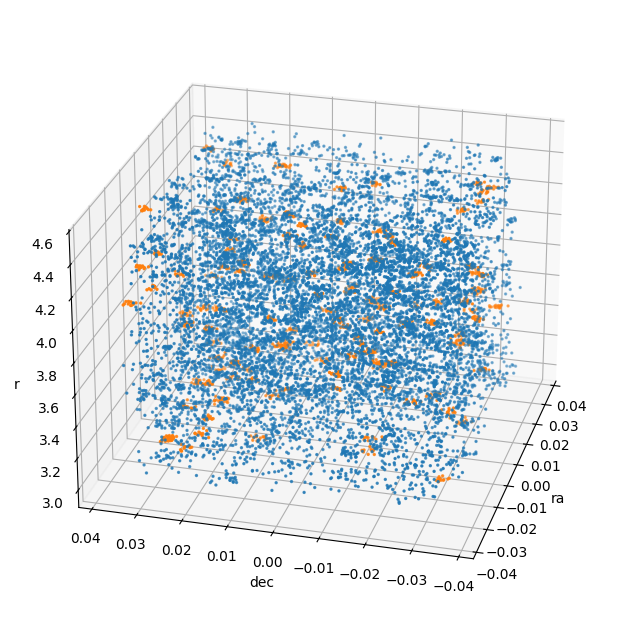

In [7]:
fig, ax = plt.subplots(figsize=[8,8], subplot_kw={'projection': '3d'})
ax.scatter(mock[mock["label"]==0]["ra"], mock[mock["label"]==0]["dec"], mock[mock["label"]==0]["r"], s=2)
ax.scatter(mock[mock["label"]==1]["ra"], mock[mock["label"]==1]["dec"], mock[mock["label"]==1]["r"], s=2)
ax.view_init(elev=25, azim=195)
ax.set_xlabel("ra")
ax.set_ylabel("dec")
ax.set_zlabel("r")

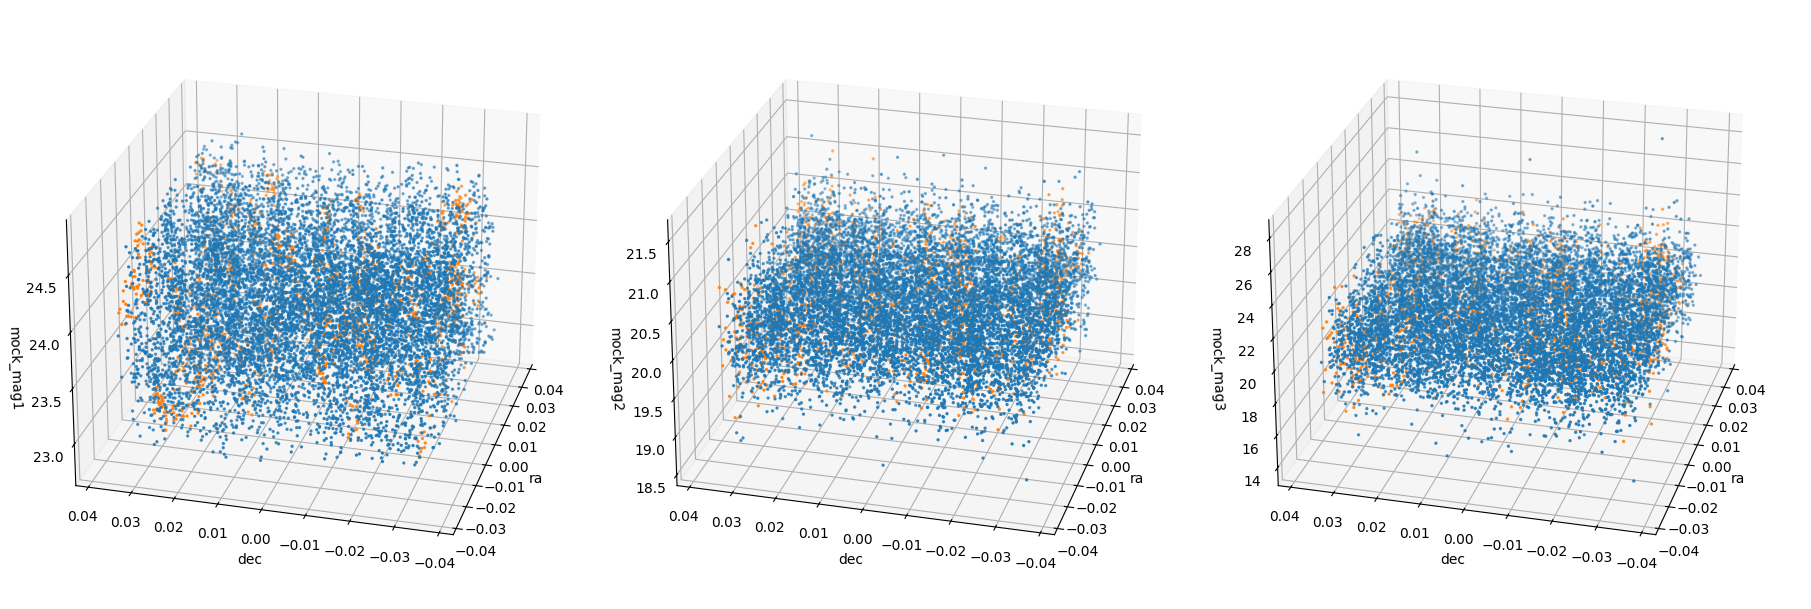

In [ ]:
fig, ax = plt.subplots(1,3,figsize=[18,8], subplot_kw={'projection': '3d'},layout='constrained')
for i in range(3):
    ax[i].scatter(mock[mock["label"]==0]["ra"], mock[mock["label"]==0]["dec"], mock[mock["label"]==0][f"mock_mag{i+1}"], s=2)
    ax[i].scatter(mock[mock["label"]==1]["ra"], mock[mock["label"]==1]["dec"], mock[mock["label"]==1][f"mock_mag{i+1}"], s=2)
    ax[i].view_init(elev=25, azim=195)
    ax[i].set_xlabel("ra")
    ax[i].set_ylabel("dec")
    ax[i].set_zlabel(f"mock_mag{i+1}")


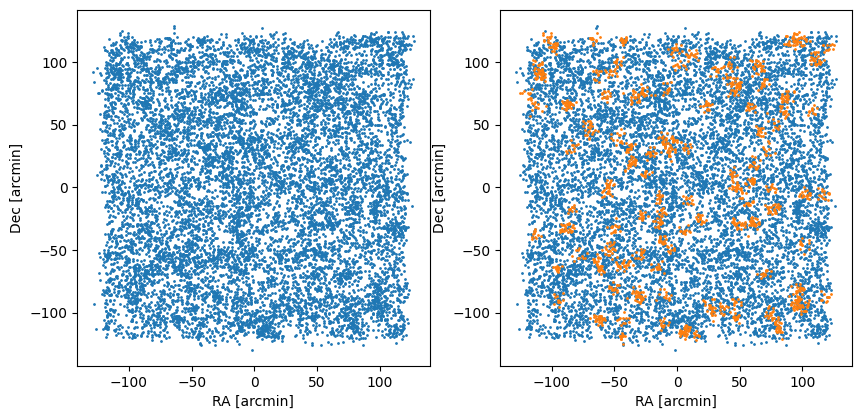

In [9]:
fig, ax = plt.subplots(1,2,figsize=[10,5],)
ax[0].scatter(mock["ra_arcmin"], mock["dec_arcmin"], s=1)
ax[1].scatter(mock.query("label==0")["ra_arcmin"], mock.query("label==0")["dec_arcmin"], s=1)
ax[1].scatter(mock.query("label==1")["ra_arcmin"], mock.query("label==1")["dec_arcmin"], s=1)
ax[0].set_xlabel("RA [arcmin]")
ax[0].set_ylabel("Dec [arcmin]")
ax[1].set_xlabel("RA [arcmin]")
ax[1].set_ylabel("Dec [arcmin]")
ax[0].set_aspect('equal')
ax[1].set_aspect('equal')

Text(0, 0.5, '$N$')

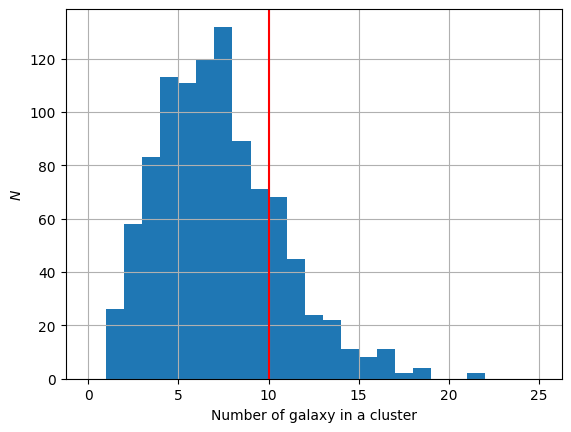

In [10]:
fig, ax = plt.subplots()
mock.query("cluster_id!=0").groupby(["cluster_id"])["ra"].count().hist(bins=25, range=[0,25],ax=ax)
ax.set_ylim(*(ax.get_ylim()))
ax.vlines(10, 0, ax.get_ylim()[1], color="red")
ax.set_xlabel("Number of galaxy in a cluster")
ax.set_ylabel("$N$")

# Trarining

In [11]:
import logging
logger = logging.getLogger(__name__)
flh = logging.FileHandler(args.logfile)
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(message)s', level=logging.DEBUG,
                handlers=[flh])

processor = Trainer(args)
processor.start()

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 100000/100000 [15:14<00:00, 109.41it/s]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/594 [00:00<?, ?it/s]

EPOCH: 0, Train [Loss: 0.377, ROC_AUC: 0.746, PR_AUC: 0.347]
 Valid [Loss: 0.335, ROC_AUC: 0.733, PR_AUC: 0.471]


  0%|          | 0/594 [00:00<?, ?it/s]

EPOCH: 1, Train [Loss: 0.350, ROC_AUC: 0.798, PR_AUC: 0.418]
 Valid [Loss: 0.371, ROC_AUC: 0.752, PR_AUC: 0.487]


  0%|          | 0/594 [00:00<?, ?it/s]

EPOCH: 2, Train [Loss: 0.345, ROC_AUC: 0.806, PR_AUC: 0.435]
 Valid [Loss: 0.303, ROC_AUC: 0.758, PR_AUC: 0.496]


  0%|          | 0/594 [00:00<?, ?it/s]

EPOCH: 3, Train [Loss: 0.342, ROC_AUC: 0.811, PR_AUC: 0.443]
 Valid [Loss: 0.404, ROC_AUC: 0.753, PR_AUC: 0.487]


  0%|          | 0/594 [00:00<?, ?it/s]

EPOCH: 4, Train [Loss: 0.339, ROC_AUC: 0.817, PR_AUC: 0.446]
 Valid [Loss: 0.306, ROC_AUC: 0.761, PR_AUC: 0.496]


  0%|          | 0/594 [00:00<?, ?it/s]

EPOCH: 5, Train [Loss: 0.337, ROC_AUC: 0.818, PR_AUC: 0.455]
 Valid [Loss: 0.307, ROC_AUC: 0.762, PR_AUC: 0.498]


  0%|          | 0/594 [00:00<?, ?it/s]

EPOCH: 6, Train [Loss: 0.336, ROC_AUC: 0.820, PR_AUC: 0.460]
 Valid [Loss: 0.305, ROC_AUC: 0.770, PR_AUC: 0.497]


  0%|          | 0/594 [00:00<?, ?it/s]

EPOCH: 7, Train [Loss: 0.328, ROC_AUC: 0.830, PR_AUC: 0.478]
 Valid [Loss: 0.296, ROC_AUC: 0.779, PR_AUC: 0.510]


  0%|          | 0/594 [00:00<?, ?it/s]

EPOCH: 8, Train [Loss: 0.326, ROC_AUC: 0.833, PR_AUC: 0.486]
 Valid [Loss: 0.298, ROC_AUC: 0.774, PR_AUC: 0.506]


  0%|          | 0/594 [00:00<?, ?it/s]

EPOCH: 9, Train [Loss: 0.327, ROC_AUC: 0.833, PR_AUC: 0.486]
 Valid [Loss: 0.295, ROC_AUC: 0.776, PR_AUC: 0.508]


  0%|          | 0/594 [00:00<?, ?it/s]

EPOCH: 10, Train [Loss: 0.325, ROC_AUC: 0.834, PR_AUC: 0.488]
 Valid [Loss: 0.293, ROC_AUC: 0.777, PR_AUC: 0.507]


  0%|          | 0/594 [00:00<?, ?it/s]

EPOCH: 11, Train [Loss: 0.325, ROC_AUC: 0.835, PR_AUC: 0.491]
 Valid [Loss: 0.293, ROC_AUC: 0.784, PR_AUC: 0.513]


  0%|          | 0/594 [00:00<?, ?it/s]

EPOCH: 12, Train [Loss: 0.325, ROC_AUC: 0.835, PR_AUC: 0.490]
 Valid [Loss: 0.295, ROC_AUC: 0.781, PR_AUC: 0.514]


  0%|          | 0/594 [00:00<?, ?it/s]

EPOCH: 13, Train [Loss: 0.324, ROC_AUC: 0.836, PR_AUC: 0.490]
 Valid [Loss: 0.293, ROC_AUC: 0.785, PR_AUC: 0.516]


  0%|          | 0/594 [00:00<?, ?it/s]

EPOCH: 14, Train [Loss: 0.322, ROC_AUC: 0.838, PR_AUC: 0.497]
 Valid [Loss: 0.297, ROC_AUC: 0.783, PR_AUC: 0.507]


  0%|          | 0/594 [00:00<?, ?it/s]

EPOCH: 15, Train [Loss: 0.322, ROC_AUC: 0.838, PR_AUC: 0.497]
 Valid [Loss: 0.291, ROC_AUC: 0.789, PR_AUC: 0.516]


  0%|          | 0/594 [00:00<?, ?it/s]

EPOCH: 16, Train [Loss: 0.323, ROC_AUC: 0.837, PR_AUC: 0.496]
 Valid [Loss: 0.293, ROC_AUC: 0.784, PR_AUC: 0.511]


  0%|          | 0/594 [00:00<?, ?it/s]

EPOCH: 17, Train [Loss: 0.322, ROC_AUC: 0.838, PR_AUC: 0.499]
 Valid [Loss: 0.293, ROC_AUC: 0.786, PR_AUC: 0.516]


  0%|          | 0/594 [00:00<?, ?it/s]

EPOCH: 18, Train [Loss: 0.321, ROC_AUC: 0.839, PR_AUC: 0.502]
 Valid [Loss: 0.291, ROC_AUC: 0.785, PR_AUC: 0.517]


  0%|          | 0/594 [00:00<?, ?it/s]

EPOCH: 19, Train [Loss: 0.321, ROC_AUC: 0.840, PR_AUC: 0.504]
 Valid [Loss: 0.290, ROC_AUC: 0.786, PR_AUC: 0.524]


  0%|          | 0/594 [00:00<?, ?it/s]

EPOCH: 20, Train [Loss: 0.321, ROC_AUC: 0.840, PR_AUC: 0.504]
 Valid [Loss: 0.290, ROC_AUC: 0.785, PR_AUC: 0.518]


  0%|          | 0/594 [00:00<?, ?it/s]

EPOCH: 21, Train [Loss: 0.321, ROC_AUC: 0.840, PR_AUC: 0.503]
 Valid [Loss: 0.290, ROC_AUC: 0.787, PR_AUC: 0.519]


  0%|          | 0/594 [00:00<?, ?it/s]

EPOCH: 22, Train [Loss: 0.321, ROC_AUC: 0.840, PR_AUC: 0.506]
 Valid [Loss: 0.288, ROC_AUC: 0.785, PR_AUC: 0.514]


  0%|          | 0/594 [00:00<?, ?it/s]

EPOCH: 23, Train [Loss: 0.320, ROC_AUC: 0.842, PR_AUC: 0.502]
 Valid [Loss: 0.293, ROC_AUC: 0.785, PR_AUC: 0.523]


  0%|          | 0/594 [00:00<?, ?it/s]

EPOCH: 24, Train [Loss: 0.320, ROC_AUC: 0.842, PR_AUC: 0.505]
 Valid [Loss: 0.290, ROC_AUC: 0.785, PR_AUC: 0.515]


  0%|          | 0/594 [00:00<?, ?it/s]

EPOCH: 25, Train [Loss: 0.319, ROC_AUC: 0.842, PR_AUC: 0.508]
 Valid [Loss: 0.289, ROC_AUC: 0.788, PR_AUC: 0.516]


  0%|          | 0/594 [00:00<?, ?it/s]

EPOCH: 26, Train [Loss: 0.318, ROC_AUC: 0.843, PR_AUC: 0.507]
 Valid [Loss: 0.289, ROC_AUC: 0.790, PR_AUC: 0.524]


  0%|          | 0/594 [00:00<?, ?it/s]

EPOCH: 27, Train [Loss: 0.318, ROC_AUC: 0.845, PR_AUC: 0.511]
 Valid [Loss: 0.291, ROC_AUC: 0.784, PR_AUC: 0.520]


  0%|          | 0/594 [00:00<?, ?it/s]

EPOCH: 28, Train [Loss: 0.318, ROC_AUC: 0.842, PR_AUC: 0.508]
 Valid [Loss: 0.289, ROC_AUC: 0.786, PR_AUC: 0.520]


  0%|          | 0/594 [00:00<?, ?it/s]

EPOCH: 29, Train [Loss: 0.317, ROC_AUC: 0.844, PR_AUC: 0.509]
 Valid [Loss: 0.287, ROC_AUC: 0.789, PR_AUC: 0.520]


  0%|          | 0/594 [00:00<?, ?it/s]

EPOCH: 30, Train [Loss: 0.318, ROC_AUC: 0.844, PR_AUC: 0.510]
 Valid [Loss: 0.289, ROC_AUC: 0.786, PR_AUC: 0.518]


  0%|          | 0/594 [00:00<?, ?it/s]

EPOCH: 31, Train [Loss: 0.318, ROC_AUC: 0.843, PR_AUC: 0.508]
 Valid [Loss: 0.287, ROC_AUC: 0.791, PR_AUC: 0.520]


  0%|          | 0/594 [00:00<?, ?it/s]

EPOCH: 32, Train [Loss: 0.316, ROC_AUC: 0.845, PR_AUC: 0.512]
 Valid [Loss: 0.289, ROC_AUC: 0.784, PR_AUC: 0.514]


  0%|          | 0/594 [00:00<?, ?it/s]

EPOCH: 33, Train [Loss: 0.318, ROC_AUC: 0.843, PR_AUC: 0.511]
 Valid [Loss: 0.287, ROC_AUC: 0.791, PR_AUC: 0.521]


  0%|          | 0/594 [00:00<?, ?it/s]

EPOCH: 34, Train [Loss: 0.317, ROC_AUC: 0.845, PR_AUC: 0.511]
 Valid [Loss: 0.287, ROC_AUC: 0.789, PR_AUC: 0.519]


  0%|          | 0/594 [00:00<?, ?it/s]

EPOCH: 35, Train [Loss: 0.317, ROC_AUC: 0.845, PR_AUC: 0.511]
 Valid [Loss: 0.289, ROC_AUC: 0.788, PR_AUC: 0.522]


  0%|          | 0/594 [00:00<?, ?it/s]

EPOCH: 36, Train [Loss: 0.317, ROC_AUC: 0.844, PR_AUC: 0.512]
 Valid [Loss: 0.289, ROC_AUC: 0.787, PR_AUC: 0.514]


  0%|          | 0/594 [00:00<?, ?it/s]

EPOCH: 37, Train [Loss: 0.317, ROC_AUC: 0.845, PR_AUC: 0.511]
 Valid [Loss: 0.289, ROC_AUC: 0.783, PR_AUC: 0.515]


  0%|          | 0/594 [00:00<?, ?it/s]

EPOCH: 38, Train [Loss: 0.317, ROC_AUC: 0.844, PR_AUC: 0.510]
 Valid [Loss: 0.287, ROC_AUC: 0.787, PR_AUC: 0.517]


  0%|          | 0/594 [00:00<?, ?it/s]

EPOCH: 39, Train [Loss: 0.318, ROC_AUC: 0.844, PR_AUC: 0.510]
 Valid [Loss: 0.289, ROC_AUC: 0.788, PR_AUC: 0.524]


  0%|          | 0/594 [00:00<?, ?it/s]

EPOCH: 40, Train [Loss: 0.316, ROC_AUC: 0.845, PR_AUC: 0.511]
 Valid [Loss: 0.289, ROC_AUC: 0.784, PR_AUC: 0.518]


  0%|          | 0/594 [00:00<?, ?it/s]

EPOCH: 41, Train [Loss: 0.317, ROC_AUC: 0.844, PR_AUC: 0.510]
 Valid [Loss: 0.287, ROC_AUC: 0.790, PR_AUC: 0.525]


  0%|          | 0/594 [00:00<?, ?it/s]

EPOCH: 42, Train [Loss: 0.317, ROC_AUC: 0.845, PR_AUC: 0.511]
 Valid [Loss: 0.288, ROC_AUC: 0.791, PR_AUC: 0.521]


  0%|          | 0/594 [00:00<?, ?it/s]

EPOCH: 43, Train [Loss: 0.317, ROC_AUC: 0.845, PR_AUC: 0.515]
 Valid [Loss: 0.288, ROC_AUC: 0.790, PR_AUC: 0.520]
early stop!


  0%|          | 0/168 [00:00<?, ?it/s]

# Evauate

In [12]:
result = pd.concat([
    pd.read_hdf("output/result/result_pred_mock_PCFNet.h5", key=f"0/{idx}/pred")
    for idx in args.test_ids])
result.head()

,lightcone_id,index,pred,true
10709,mock_8,0,0.136401,0
10710,mock_8,1,0.188680,0
10711,mock_8,2,0.243743,0
10712,mock_8,3,0.242152,0
10713,mock_8,4,0.218244,0


In [13]:
data = {}
for idx in args.test_ids:
    data[idx] = pd.read_hdf("output/preprocess/mock4pcfnet.h5", key=f"{idx}/data")
all_data = pd.concat([d for d in data.values()])

In [14]:
mean_2d_density = sum([d.shape[0] for d in data.values()]) / (4. * 60)**2 / len(data)  # /arcmin^2
for i, df in (data.items()):
    delta2d = util.cal_delta_density2d(
            df[['ra_arcmin', 'dec_arcmin']],
            df[['ra_arcmin', 'dec_arcmin']],
            args.surface_density_radius,
            mean_2d_density
    )
    data[i] = pd.merge(data[i], delta2d, left_index=True, right_index=True)
all_data = pd.concat([d for d in data.values()])

AUC of PCFNet: 0.509
AUC of surface density method: 0.345


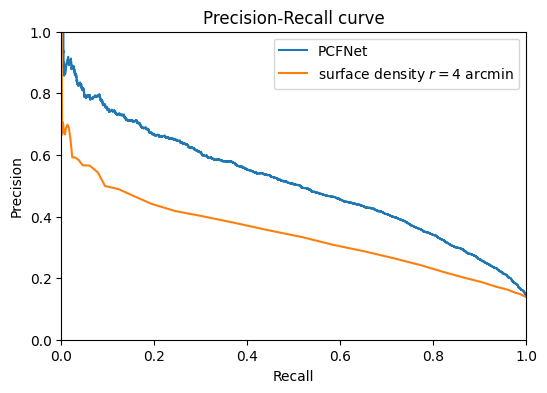

In [15]:
### Plot pr curve
fig, ax = plt.subplots(figsize=[6,4])

pr_curve = metrics.precision_recall_curve(result["true"], result["pred"])
print("AUC of PCFNet: {:.3f}".format(metrics.auc(pr_curve[1], pr_curve[0])))
ax.plot(pr_curve[1], pr_curve[0], label="PCFNet")

pr_curve = metrics.precision_recall_curve(all_data["label"], all_data["delta2d_4"])
print("AUC of surface density method: {:.3f}".format(metrics.auc(pr_curve[1], pr_curve[0])))
ax.plot(pr_curve[1], pr_curve[0], label="surface density $r=4$ arcmin")

ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("Precision-Recall curve")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.legend()
